# Vehicle Detection

The objetcive of these project is to provide a method capable of recognizing and higlighting cars within a video feed. 

To reach this objective, I will explore some methods to extract relevant features from an image to train a classifier capable of recognizing whether a car is present on that picture or not.

With this techinques we will generate a heatmap of possible car locations and I will implement some simple methods to try and reduce the number of possible false positives and attempt to delimit all cars in the image with a bounding box.

In [1]:
import glob
import random

import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import SelectFromModel

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

from scipy.ndimage.measurements import label

from moviepy.editor import *
from IPython.display import HTML

In [2]:
# CONSTANTS
_FOLDER_VEHICLE_ = "training/vehicles/"
_FOLDER_NON_VEHICLE_ = "training/non-vehicles/"
_FOLDER_TEST_IMAGES_ = "test_images/"
_FOLDER_VALIDATION_ = "validation_images/"

files_vehicles = glob.glob(_FOLDER_VEHICLE_ + "*/*.png")
files_other = glob.glob(_FOLDER_NON_VEHICLE_ + "*/*.png")
files_test = glob.glob(_FOLDER_TEST_IMAGES_ + "*.jpg") 
files_validation_true = glob.glob(_FOLDER_VALIDATION_ + "true/*.png") 
files_validation_false = glob.glob(_FOLDER_VALIDATION_ + "false/*.png") 

_TEST_VIDEO_ = "test_video.mp4"
_PROJECT_VIDEO_ = "project_video.mp4"

## Data Acquisition and Feature Extraction

To try to provide relevant data to a classifier, it is important to extract relevant features from an image to maximize its performance when trying to distinguish an image with a car from an image without a car. 

My initial strategy for feature extraction is generating a vector with an extensive set of features for every image that will later be fitted on various types of classifiers. However, using an extensive array of features has an important impact on the performance of this method and, thus, I will later perform feature reduction to try and select a subset of features both capable of  generating good predictions and doing that in a more resonable span of time.

The feature vector will be comprised of three main types of features: raw pixel data, layer histograms and HOG. I will try to use different colorspaces for each  type of feature to try to maximize performance and try to avoid heavy correlation between them. For example, a heavy red image would show that in RGB would show high red values both in raw pixel data and after computing the color histogram for the red layer.

First, I will use raw pixel data from the RGB image to try to represent spacial information of the image. The resoning behing using the RGB colorpace is that it might be helpful in pinpointing comon data present in all cars that tend to be in similar places like red brake lights, white plates, black tyres...

For the layer histograms, I will use all layers from the YCrCb colorspace to both get important color information from the chroma channels (image with cars might have a heavy presence of a color while images with no cars might not be so pronunced) and a histogram of a color-independent layer (Y) that might be more dependent on common features and shapes. For example, we might get similar values for the darkest side of the Y spectrum due to the tyres being black.

Finally, to extract direct shape information from the image we will use the HOG method that returns a kind of gradient vector for different subsets of the image. The Saturation and Value layers of the HSV colorspace tend to maximize the difference between the car and the backgroung and are giving me great results with HOG.

In [3]:
# Define a function that takes an single layer image
# and return an array of HOG features
def GetHogFeatures(image):
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    
    output = hog(image, orientations=orient, 
                 pixels_per_cell=(pix_per_cell, pix_per_cell),
                 cells_per_block=(cell_per_block, cell_per_block),
                 transform_sqrt=True, 
                 visualise=False, feature_vector=True)
    return output

# Define a function that returns the color histogram 
# for each channel of the image
def GetHistogram(image, nbins=32):
    c0 = np.histogram(image[:,:,0], bins=nbins)
    c1 = np.histogram(image[:,:,1], bins=nbins)
    c2 = np.histogram(image[:,:,2], bins=nbins)
    
    return np.concatenate( (c0[0], c1[0], c2[0]) )

# Define a function that takes an image, downsamples it
# and returns it as an array of values
def GetSpacial(image, size=(32,32)):
    c0 = cv2.resize(image[:,:,0], size).ravel()
    c1 = cv2.resize(image[:,:,1], size).ravel()
    c2 = cv2.resize(image[:,:,2], size).ravel()
    
    return np.hstack( (c0, c1, c2) )

# Convert an RGB image to an array of features
# following a built-in set of criteria
def ExtractFeatures(image, hist_bins = 32):
    # Ensure image is in uint8 (just in case) and 64x64 pixels
    source = cv2.resize(image, (64,64))
    source = np.uint8(255*(source/source.max()))
    
    output = []
    
    # Spacial Information from RGB
    output.append(GetSpacial(source))
    
    # Histogram from YCrCb
    ycrcb = cv2.cvtColor(source, cv2.COLOR_RGB2YCrCb)
    output.append( GetHistogram(ycrcb) )

    # Hog from Saturation and Value
    hsv = cv2.cvtColor(source, cv2.COLOR_RGB2HSV)    
    output.append( GetHogFeatures(hsv[:,:,1]) )
    output.append( GetHogFeatures(hsv[:,:,2]) )
    
    return np.concatenate(output).astype(np.float64)

# Return a feature dataset with its paired label array
def GetDataAndLabels(subset_size):
    data = []
    labels = []

    if (subset_size <= 0):
        span = len(files_vehicles)
    else: 
        span = subset_size
        
    for i in range(span):
        image = cv2.imread(files_vehicles[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ret = ExtractFeatures(image)

        data.append(ret)
        labels.append(1)

    if (subset_size <= 0):
        span = len(files_other)
        
    for i in range(span):
        image = cv2.imread(files_other[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ret = ExtractFeatures(image)

        data.append(ret)
        labels.append(0)

    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

def GetValidationSet(subset_size = 50):
    data = []
    labels = []
    
    np.random.shuffle(files_validation_true)
    for i in range(subset_size):
        image = cv2.imread(files_validation_true[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ret = ExtractFeatures(image)

        data.append(ret)
        labels.append(1)
        
    np.random.shuffle(files_validation_false)
    for i in range(subset_size):
        image = cv2.imread(files_validation_false[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ret = ExtractFeatures(image)

        data.append(ret)
        labels.append(0)
    
    return data, labels

def DetailedPrediction(true, predict):
    true = np.array(true)
    
    index_true = (true==1)
    index_false = (true==0)
    
    pos = np.sum(predict[true==1] == 1)
    false_pos  = np.sum(predict[true==0] == 1)
    false_neg  = np.sum(predict[true==1] == 0)
    neg  = np.sum(predict[true==0] == 0)
    
    if (pos+false_pos+false_neg+neg != len(predict)):
        print("{} -- {}".format(
            pos+false_pos+false_neg+neg,
            len(predict)
            ))
    
    print("Video Set: {}\nTrue Positive: {}, False Positive: {}\nFalse Negative: {}, True Negative: {}\n".format(
        (pos+neg)/len(predict),
        pos, false_pos, false_neg, neg
        ))

In [4]:
def DisplayFeatures(image, title = ""):
    source = cv2.resize(image, (64,64))
    source = np.uint8(255*(source/source.max()))
    
    output = []
    
    # Spacial Information from RGB
    spacial = cv2.resize(source, (32,32))
    
    # Histogram from YCrCb
    ycrcb = cv2.cvtColor(source, cv2.COLOR_RGB2YCrCb)
    c0 = np.histogram(ycrcb[:,:,0], bins=32)
    c1 = np.histogram(ycrcb[:,:,1], bins=32)
    c2 = np.histogram(ycrcb[:,:,2], bins=32)

    # Hog from Saturation and Value
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    
    feat, hog1 = hog(hsv[:,:,1], orientations=orient, 
                 pixels_per_cell=(pix_per_cell, pix_per_cell),
                 cells_per_block=(cell_per_block, cell_per_block),
                 transform_sqrt=True, 
                 visualise=True, feature_vector=True)
    feat, hog2 = hog(hsv[:,:,2], orientations=orient, 
                 pixels_per_cell=(pix_per_cell, pix_per_cell),
                 cells_per_block=(cell_per_block, cell_per_block),
                 transform_sqrt=True, 
                 visualise=True, feature_vector=True)
    
    plt.figure(figsize=(15,10))
    plt.suptitle(title, fontsize=20)
    plt.subplot(331).set_title("Image")
    plt.imshow(source)
    plt.subplot(332).set_title("HOG (Saturation)")
    plt.imshow(hog1, cmap='gray')
    plt.subplot(333).set_title("HOG (Value)")
    plt.imshow(hog2, cmap='gray')
    plt.subplot(334).set_title("Spacial (Red)")
    plt.imshow(spacial[:,:,0], cmap='gray')
    plt.subplot(335).set_title("Spacial (Green)")
    plt.imshow(spacial[:,:,1], cmap='gray')
    plt.subplot(336).set_title("Spacial (Blue)")
    plt.imshow(spacial[:,:,2], cmap='gray')
    plt.subplot(337).set_title("Histogram (Y)")
    plt.bar(c0[1][:-1], c0[0])
    plt.xlim(min(c0[1]), max(c0[1]))
    plt.subplot(338).set_title("Histogram (Cr)")
    plt.bar(c1[1][:-1], c1[0])
    plt.xlim(min(c1[1]), max(c1[1]))
    plt.subplot(339).set_title("Histogram (Cb)")
    plt.bar(c2[1][:-1], c2[0])
    plt.xlim(min(c2[1]), max(c2[1]))

### Feature Extraction Examples

Here are a couple of examples of each extracted feature type for both a car image and a non-car image. HOG is using 9 orientations with 8x8 pixels per cell and 2x2 cells per block.

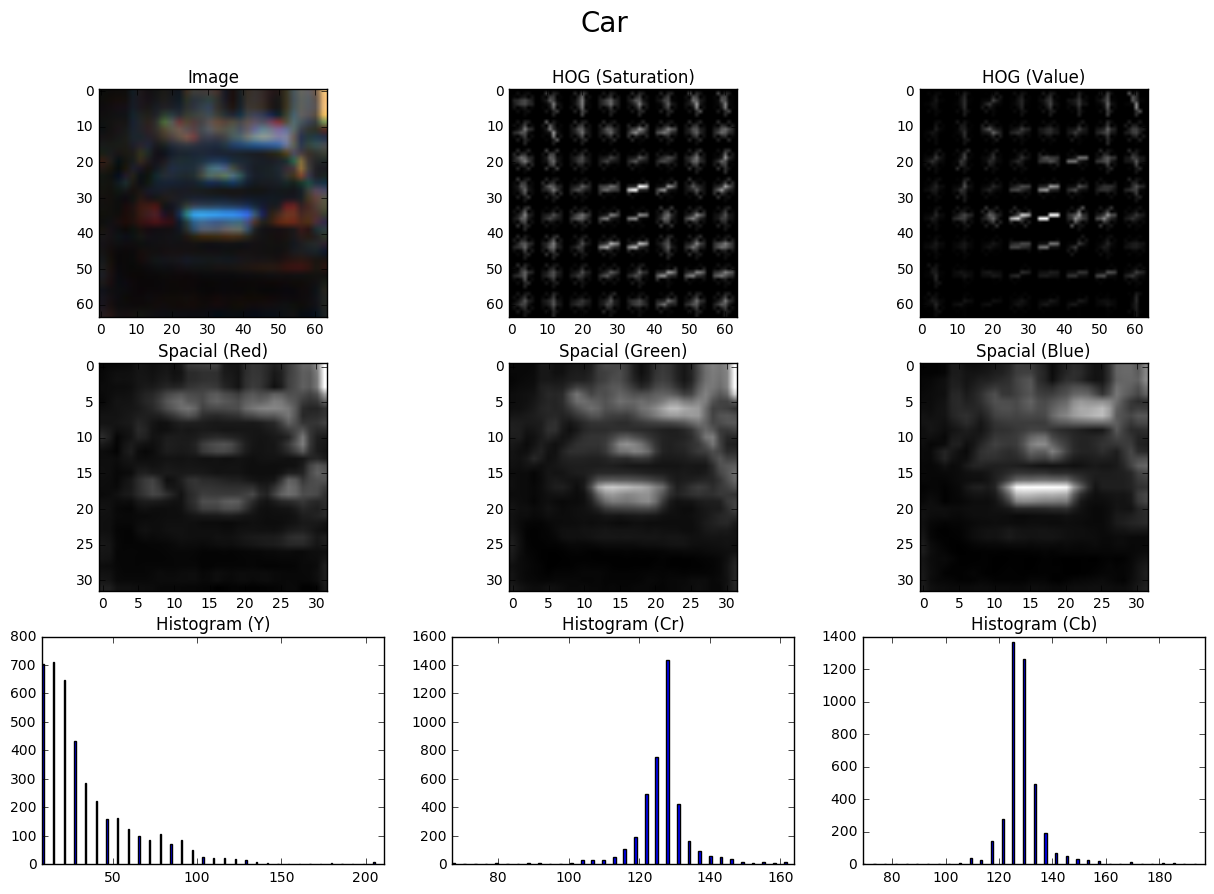

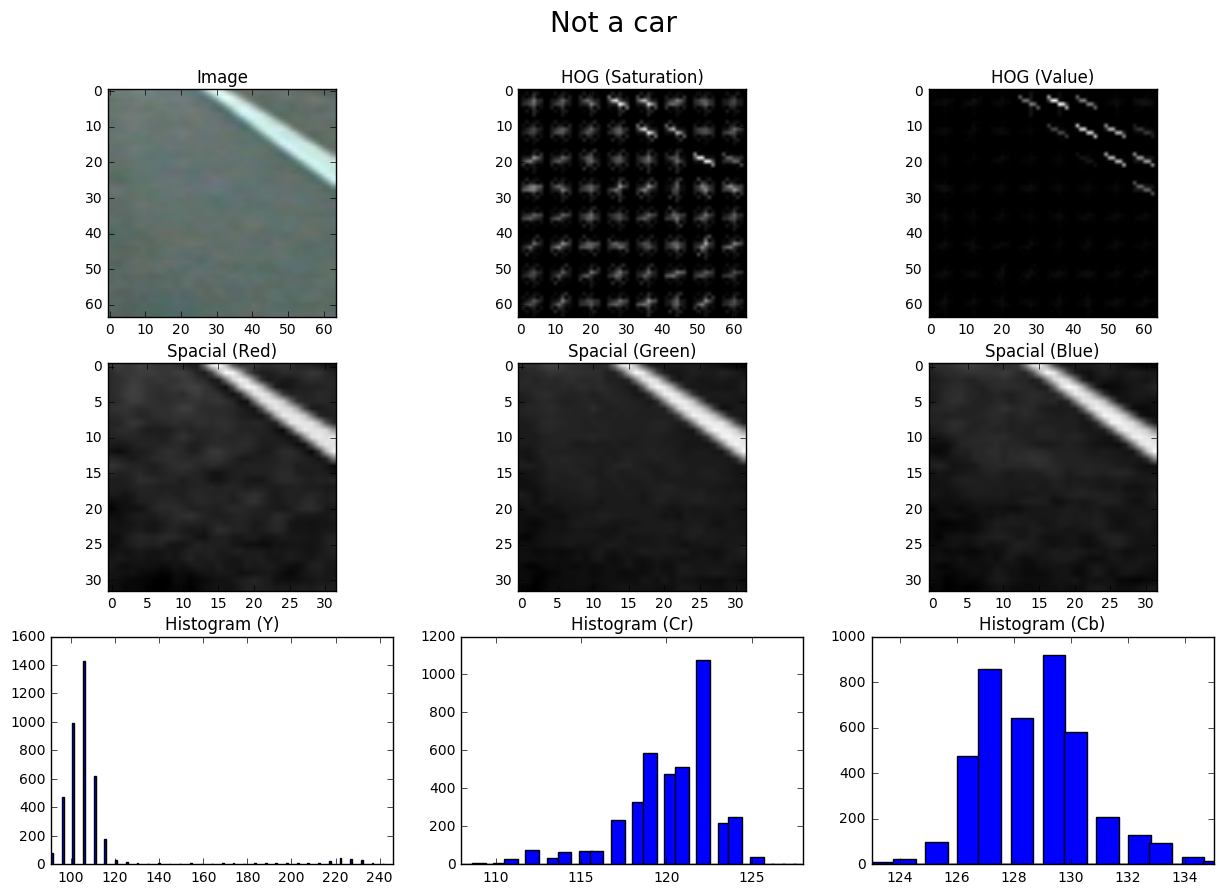

In [5]:
index = random.randint(0, len(files_vehicles))
car_img = cv2.imread(files_vehicles[index])
car_img = cv2.cvtColor(car_img, cv2.COLOR_BGR2RGB)
DisplayFeatures(car_img, "Car")

index = random.randint(0, len(files_other))
not_car_img = cv2.imread(files_other[index])
not_car_img = cv2.cvtColor(not_car_img, cv2.COLOR_BGR2RGB)
DisplayFeatures(not_car_img, "Not a car")

**Explain how you settled on your final choice of HOG parameters**

Since I will later be doing feature reduction, I made sense to try to use a reasonably large HOG vector but using more than 9 orientations didn't improve significantly the results.

## Data loading and Subset separation

To train the various classifiers, we will be using the dataset provided of images of both cars and not-cars. This dataset will be divided into a training subset and a testing subset using an stratified method.

The stratified method is not imperative because the dataset provided is reasonably well balanced between both labels (0-Not a car, 1-Car) but, just for safety, using a stratified method ensures that we don't produce randomly unbalanced subsets.

There is also a second dataset of images manually extracted from the video that will only be used to check how each method performs on slices of images taken with the camera we are using. To skewing the method on the project video, these images will not be used in training because the objective is, ultimately, get a more generalized method.

I will also be performing normalization on the feature vectors to ensure that all have similar magnitudes. This tend to improve the behaviour of any classifier as there are no dominant features due to their range of values.

In [6]:
# Get Data and Labels
data, labels = GetDataAndLabels(-1)
val_data, val_label = GetValidationSet()

print("Exploratory Analysis")
print(" Number of samples: {}".format(data.shape[0]))
print("  Non-vehicles [0]: {}".format( data.shape[0] - labels.sum() ))
print("      Vehicles [1]: {}".format( labels.sum() ))
print("Number of features: {}".format(data.shape[1]))

Exploratory Analysis
 Number of samples: 17760
  Non-vehicles [0]: 8968
      Vehicles [1]: 8792
Number of features: 6696


In [7]:
# PREPROCESS
# Scale Data
scaler = StandardScaler().fit(data)

data = scaler.transform(data)
val_data = scaler.transform(val_data)

# Split data into train and test subsets
sss = StratifiedShuffleSplit(test_size=0.25)
      
for train_index, test_index in sss.split(data, labels):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

print("Train Subset Shape: {}".format(X_train.shape))
print(" Test Subset Shape: {}".format(X_test.shape)) 

Train Subset Shape: (13320, 6696)
 Test Subset Shape: (4440, 6696)


## Car Classifier

### Prelimianry Testing

I will be doing a first fitting of the dataset on different classifiers (using their default parameters) to see how each of them perform and help me make an educated choice on which could be the most useful.

In [8]:
# Classifier Exploration
# check default results for different types of classifiers
clfs = {
    "gnb": GaussianNB(),
    "svc": SVC(kernel='linear'),
    "dtc": DecisionTreeClassifier(),
    "etc": ExtraTreesClassifier(),
    "abc": AdaBoostClassifier()
}

for i in clfs.keys():
    clfs[i].fit(X_train, y_train)
    print("{}".format(clfs[i]))
    print("Train Score: {}".format(clfs[i].score(X_train, y_train)))
    print("Test Score: {}".format(clfs[i].score(X_test, y_test)))
    DetailedPrediction(val_label, clfs[i].predict(val_data))   
    

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
Train Score: 0.9911411411411412
Test Score: 0.9835585585585586
Video Set: 0.66
True Positive: 18, False Positive: 2
False Negative: 32, True Negative: 48

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Train Score: 1.0
Test Score: 0.9927927927927928
Video Set: 0.69
True Positive: 20, False Positive: 1
False Negative: 30, True Negative: 49

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verb

Most of the classifiers that have been used have shown good performanced. 
The two that seem to perform above the rest are SVC and Extreme Tree. I will be using SVC as a classifier because it has shown to consistently perform well, even though it is not the most time efficent method.

### Feature Selection

Since Extreme Trees show good results, I will be using this classifier to perform aa feature reduction step that will help speed up both the training and prediction time of the SVC.

In [9]:
fs_model = SelectFromModel(clfs["etc"],threshold="0.5*mean" ,prefit=True)
X_fs_train = fs_model.transform(X_train)
print( "Feature Selection:\nReduced from {} features to {}.".format(X_train.shape[1], X_fs_train.shape[1]))

Feature Selection:
Reduced from 6696 features to 1899.


### Final Estimator

Finally, to get the better results possible on the classifier, I will be using Grid Search to choose the better performing C parameter of the SVC. 

In [10]:
params = {
    'C': [0.01, 0.05, 0.1, 0.5, 1],
}
svc = SVC(kernel='linear')
b_svc = GridSearchCV(svc, params, verbose=1, cv=4)
b_svc.fit(X_fs_train,y_train)

print(b_svc.best_params_)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 10.0min finished


{'C': 0.01}


In [11]:
classifier = b_svc.best_estimator_
classifier.fit(X_fs_train, y_train)
print("Test Score: {}".format(classifier.score(fs_model.transform(X_test), y_test)) )

Test Score: 0.9914414414414414


The test score shows that the feature reduction has, in fact, slightly affected the capacity of the SVC to perform its predictions but having a feature set that is roughly a third of the original extracted vector heavyly improves the running time of this method.

## Image Exploration

I will be applying the classifier on different slices of the images using sliding windows within a limited area. To chose the dimensions of each window I will be using a perspective based method. 

First, since the size of the search zone for the sliding windows can have an important impact in the runing time of each iteration of this method, it is important to limit the search zone to a relevant area. In this case, I will consider the range between the 450px and the 700px to generate positions for the lower part of a search band. This is roughly the zone between the horizon and the front of the car.

Then, I will be defining a series of horizontal bands within the relevant area to get the vertical position of the image so each window within each band has the same dimensions.

Those dimensions will depend on the vertical position of the image. Since cars that are far away tend to be smaller and closer to the horizon, the higher position windows are smaller and, as the window position gets lower, the size of the window tends to get larger as it is attempting to show things that are closer.

The function that defines the window size is a second degree polynomial function that has been manually fitted to get the desired window sizes on each band.

Finally, within each band we will position the consecutive widows with a slight overlap to try to improve the possibilities that if there is a car in a particular section, it gets recognized. Without overlap, this method might get a car spread in two different windows and the classifier might not be flexible enough to recognize those separeted parts.

Using overlap has a downside as it increases the number of windows within a band and this increases the runing time. For convenience, in my code I am defining the wOverlap as the point in percentatge within a window where we place the next one. After some testing, 0.5 generate some flickering results due to thresholding and 0.1 makes the runing time unacceptable. I found that 0.33 produce results that are more precise whithin a manageable time.

In [12]:
# Vertical Range where we will place windows
scan_range = (450, 700)

# Number of Vertical Slices to divide the 
# exploration area.
scan_bands = 15

# Point (in percentage) within a window 
# where the next window starts
wOverlap = 0.33 

# Fuction that defines the window height
# depending on the vertical position within
# the exploration range (the function starts
# at y = 0)
def GetWindowHeight(y):
    #return (-0.0015 * y * y + 0.951 * y + 48) 
    return (-0.0013 * y * y + 1.152 * y + 48) 

In [13]:
display_bands = 4
wOverlap_display = 1.5
def DisplayWindows(image):
    output = image.copy()
    
    # Define vertical step
    yStep = (int)((scan_range[1]-scan_range[0]) / display_bands)
    
    for i in range(display_bands):
        # Define window height depending on the vertical position
        # higher windows are smaller (as they are far away seen 
        # in perspective)
        wHeight = (int)(GetWindowHeight(i*yStep)) # window height
        wWidth = (int)(wHeight) # window width (square window)

        # Step depends on window width and "overlap" ratio
        # "overlap" is actually the %point within the current
        # window where the next window starts.
        # Therefore, a lower "overlap" imply more windows per band
        xStep = (int)(wWidth * wOverlap_display)
        nWindows = (int)(1 + (image.shape[1] - wWidth)/(xStep))
        
        # Since the nWindows are not a guaranted 
        # perfect fit for the image, set an offset that
        # centers the band
        offset = 0.5*(image.shape[1] - wWidth - ( (nWindows-1) * xStep))

        for j in range(nWindows):
            # Get top right corner position of the image
            x = (int)(offset + j*xStep)
            y = (int)(scan_range[0] + i * yStep - wHeight)
    
            color = [
                255*i/display_bands,
                255 - 255*i/display_bands,
                255*j/nWindows
            ]
            output = cv2.rectangle(output, (x,y), (x+wWidth,y+wHeight), color, 4)
            
    plt.figure()
    plt.imshow(output)
    plt.show()

Here are a couple of examples of the sliding window method used. The version used in the vehicle recogision method uses more bands and has some horizontal overlap to try to get better results but it is much more cahotic to display.

By reducing the number of windows in the image, one might get a better sense of this perspective driven method.

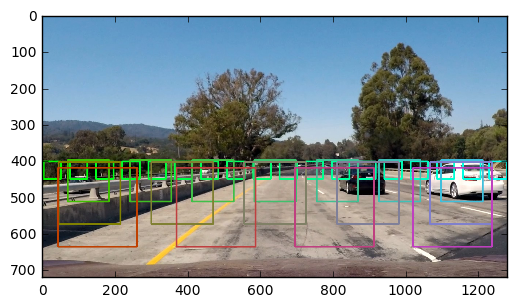

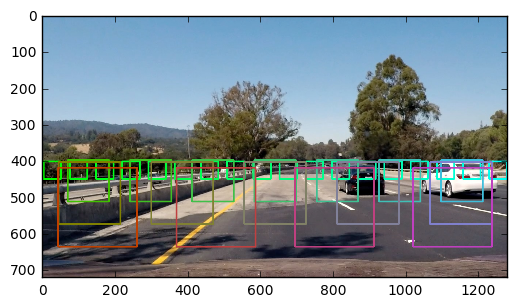

In [14]:
image_set = [0,3]

for i in image_set:
    image = cv2.imread(files_test[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    DisplayWindows(image)

In [15]:
def GetCarHeatmap(image, feat_scaler, feat_reduction, estimator):
    # Create output canvas
    mask = np.zeros_like(image[:,:,0])
    found_count = 0

    # Define vertical step
    yStep = (int)((scan_range[1]-scan_range[0]) / scan_bands)
    
    for i in range(scan_bands):
        # Define window height depending on the vertical position
        # higher windows are smaller (as they are far away seen 
        # in perspective)
        wHeight = (int)(GetWindowHeight(i*yStep)) # window height
        wWidth = (int)(wHeight) # window width (square window)

        # Step depends on window width and "overlap" ratio
        # "overlap" is actually the %point within the current
        # window where the next window starts.
        # Therefore, a lower "overlap" imply more windows per band
        xStep = (int)(wWidth * wOverlap)
        nWindows = (int)(1 + (image.shape[1] - wWidth)/(xStep))
        
        # Since the nWindows are not a guaranted 
        # perfect fit for the image, set an offset that
        # centers the band
        offset = 0.5*(image.shape[1] - wWidth - ( (nWindows-1) * xStep))

        for j in range(nWindows):
            # Get top right corner position of the image
            x = (int)(offset + j*xStep)
            y = (int)(scan_range[0] + i * yStep - wHeight)
    
            # Get the image Slice
            imgSlice = image[y:y+wHeight, x:x+wWidth]
            
            # Extract data from image and apply scaling
            data = ExtractFeatures(imgSlice).reshape(1,-1)
            scaled_data = feat_scaler.transform(data)
            reduced_data = feat_reduction.transform(scaled_data)
            # Cast a prediction
            prediction = estimator.predict(reduced_data)
            
            if (prediction[0] == 1):
                # if a car is detected, increase the mask values
                # on the designated area
                mask[y:y+wHeight, x:x+wWidth] += 1
                found_count += 1

            #plt.figure()
            #plt.imshow(image[y:y+wHeight, x:x+wWidth])
            #plt.suptitle("[{}, {}] ({})".format(x,y,prediction))
            #plt.show()
    #print("Matches found: {}".format(found_count))
    return mask

Here are some examples of how this method generates a heatmap trying to recognize cars within an image.

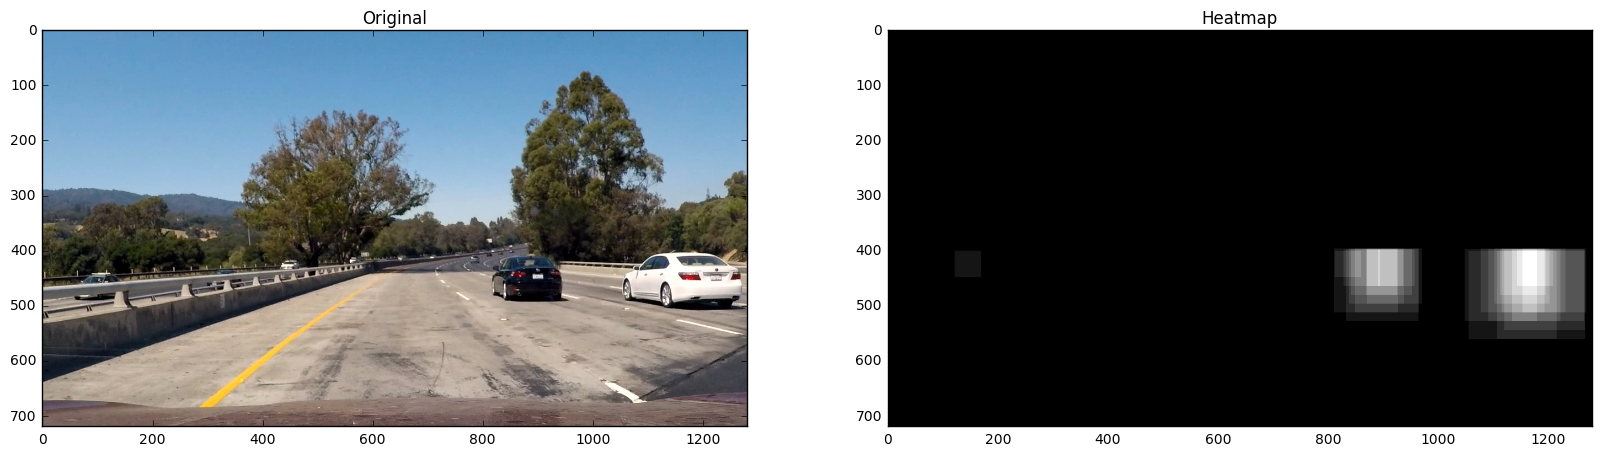

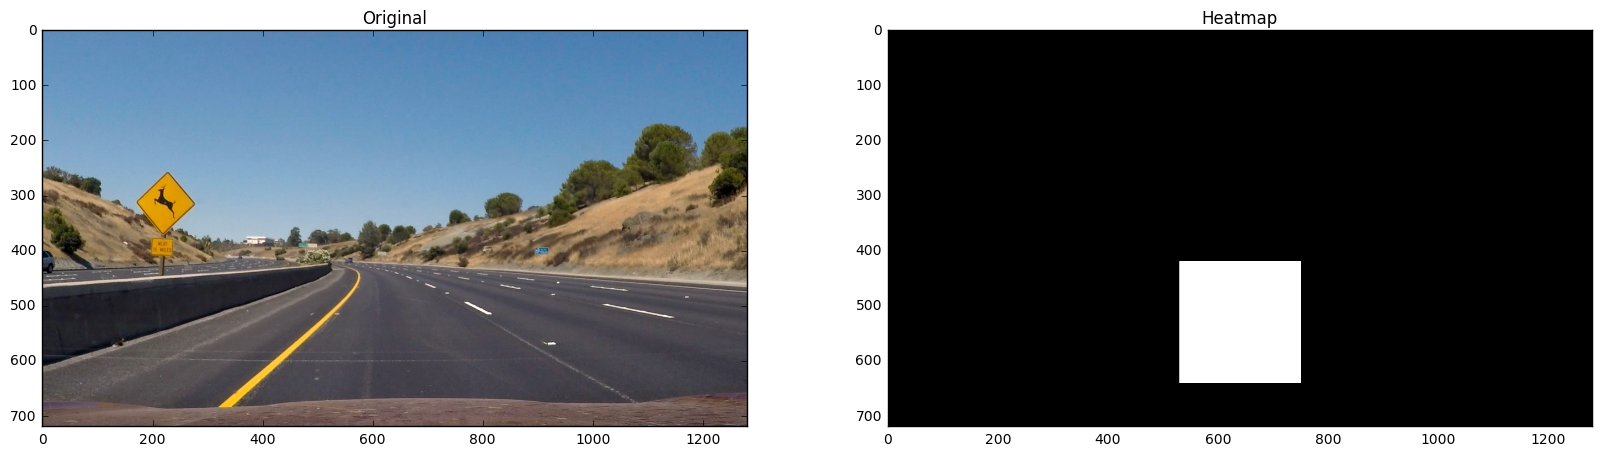

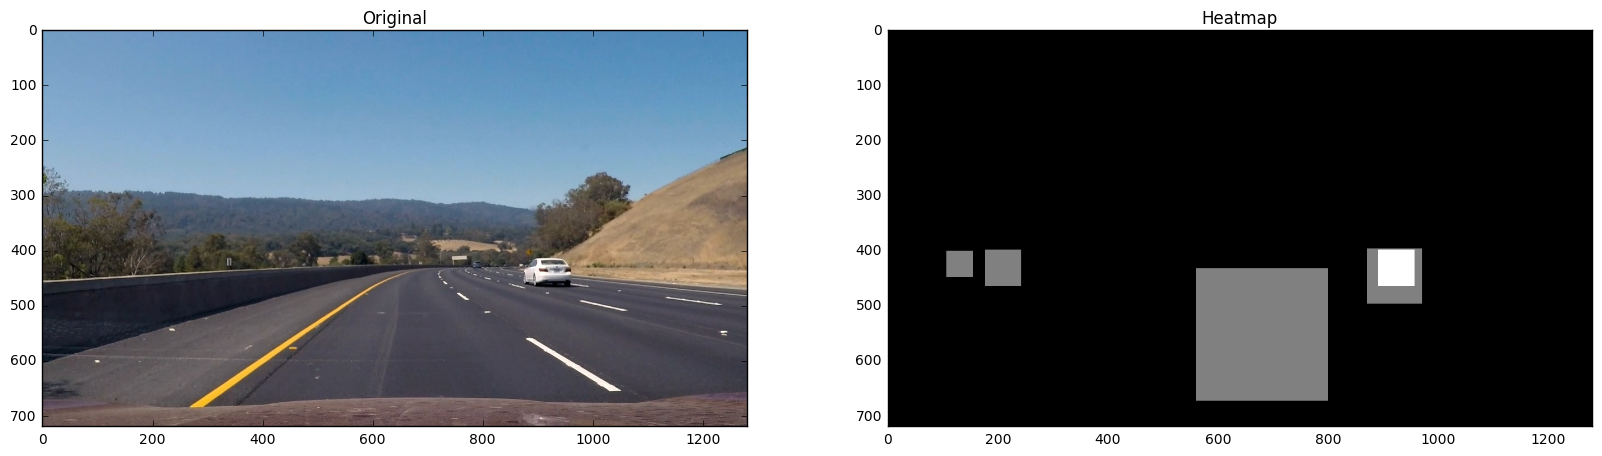

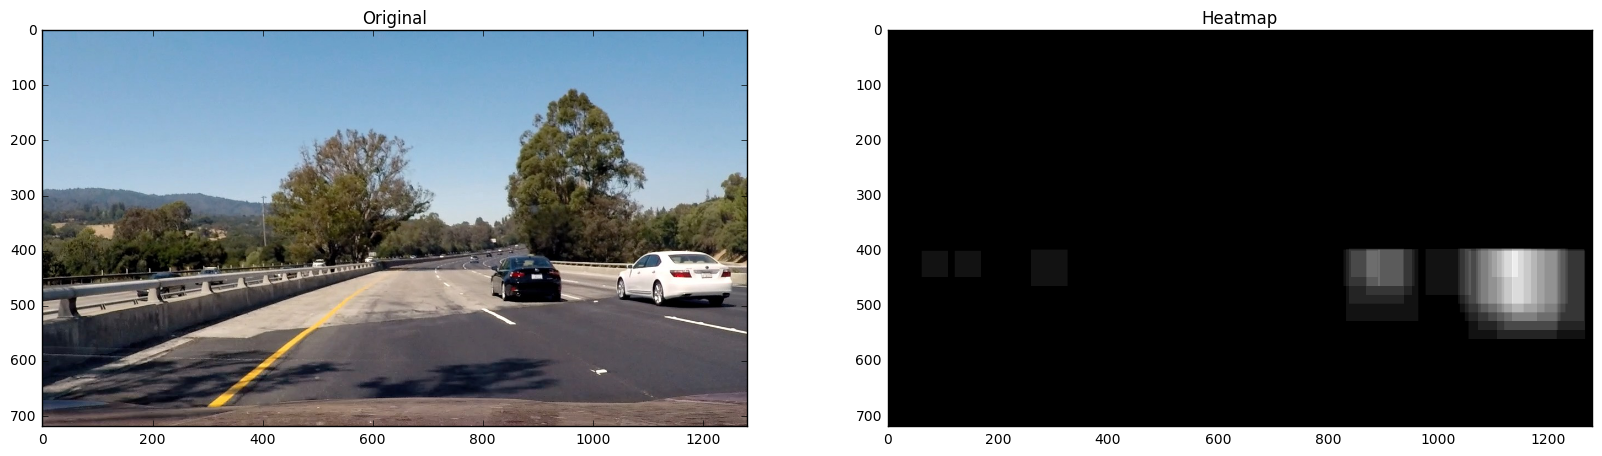

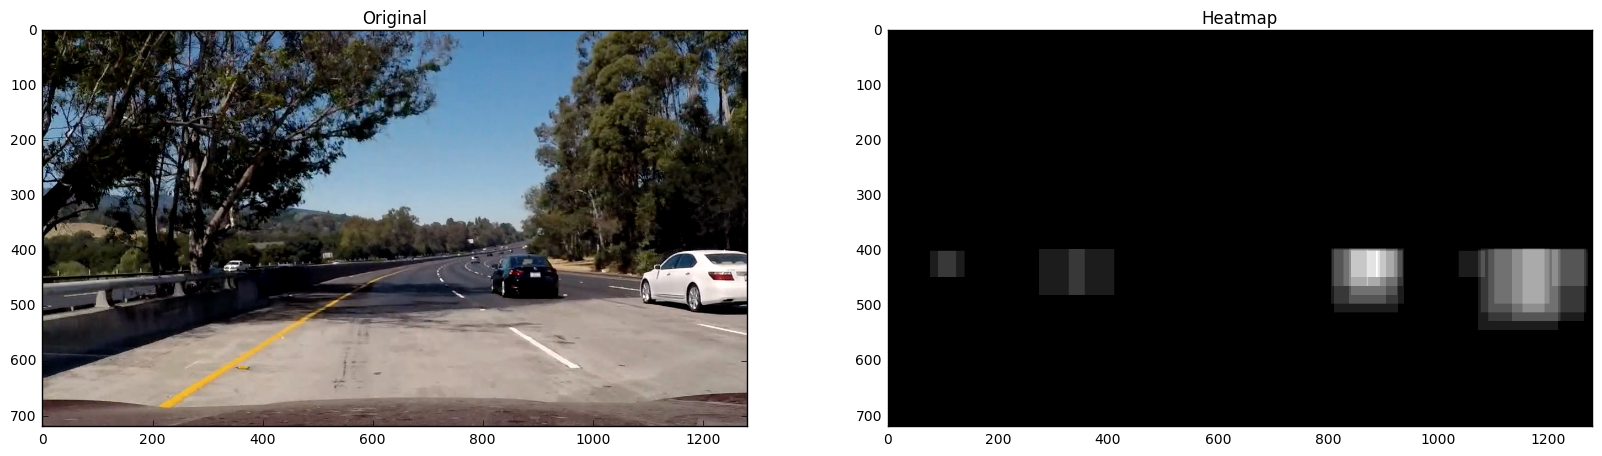

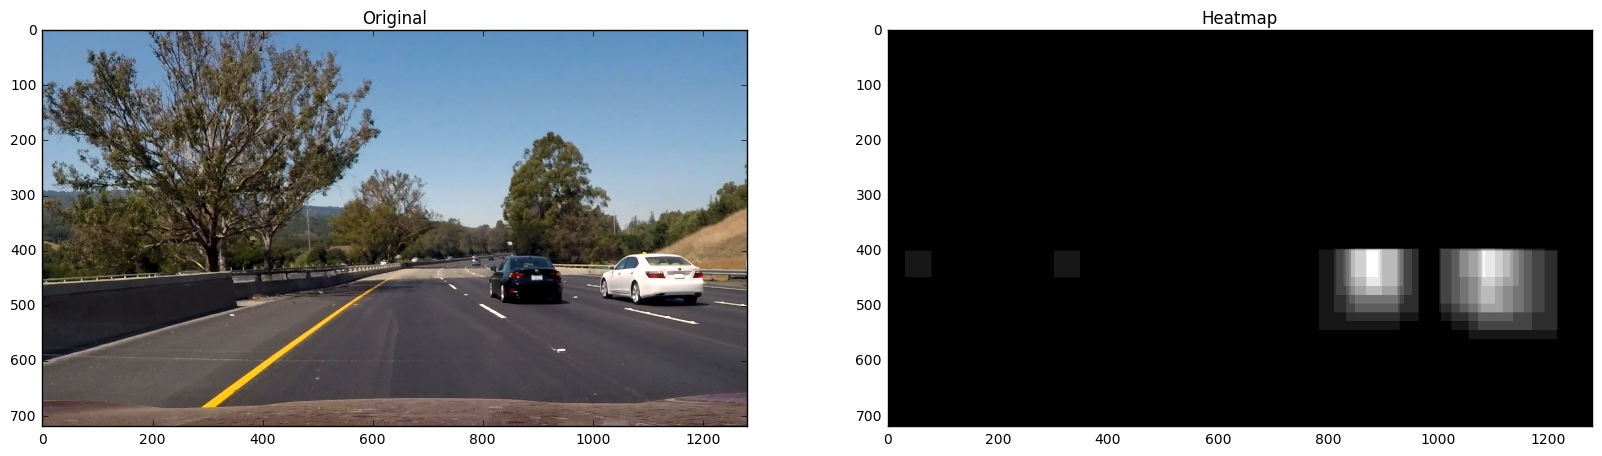

In [16]:
for i in range(len(files_test)):
    image = cv2.imread(files_test[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = GetCarHeatmap(image,scaler, fs_model, classifier)
    
    plt.figure(figsize=(20,10))
    plt.subplot(121).set_title("Original")
    plt.imshow(image)
    plt.subplot(122).set_title("Heatmap")
    #plt.imshow(display)
    plt.imshow(np.uint8(mask),cmap='gray')
    plt.show()

In [17]:
# The Car class will store the centroid of the detected shape
# (x,y) and its width and height
class Car:
    x = 0
    y = 0
    width = 0
    height = 0
    
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        
# Set a Heatmap Threshold to distinguish noise from
# relevant zones
def BinarizeHeatmap(heatmap, threshold = 2):
    if (heatmap.max() > 0):
        heatmap[heatmap < threshold] = 0
        heatmap[heatmap > 0] = 1
    else:
        heatmap = np.zeros_like(heatmap)
    
    return heatmap
        
# Return an array of Cars from a binarized heatmap
def GetCars(heatmap):
    labels = label(heatmap)

    cars = []

    for i in range(labels[1]):
        minimum = np.min(np.where(labels[0] == i+1), axis=1)
        maximum = np.max(np.where(labels[0] == i+1), axis=1)

        cars.append( Car(
            0.5*(maximum[1]+minimum[1]),
            0.5*(maximum[0]+minimum[0]),
            maximum[1]-minimum[1],
            maximum[0]-minimum[0]
        ))
    return cars

# Draw a rectangle for each detected car in an image
def DrawRectangles(image, cars):
    rects = image.copy()
    for car in cars:
        x = (int)(car.x - 0.5*car.width)
        y = (int)(car.y - 0.5*car.height)

        rects = cv2.rectangle(rects, (x,y), (x+car.width, y+car.height), [255,0,0], 4)
        
    return rects

### Reduction of false positives by thresholding on the heatmap

To try to reduce the incidence of false positives, the proposed method performs a thresholding and binarization on the heatmap to discard areas with a low number of positive predictions. It is important to not we excesively rough with the threshold as it might filter relevant predictions and we will also applying other techniques in the video implementation to further reduce the incidence of false positives.

I use the labeling method from scypi to isolate each relevant region in the heatmap and saving it as a "Car" instance in an array. Using a custom class for the car might be an overkill in the present implementation but it might be useful to further improve the method.

Here are some examples of how the method works and predicts a bounding box for each car.

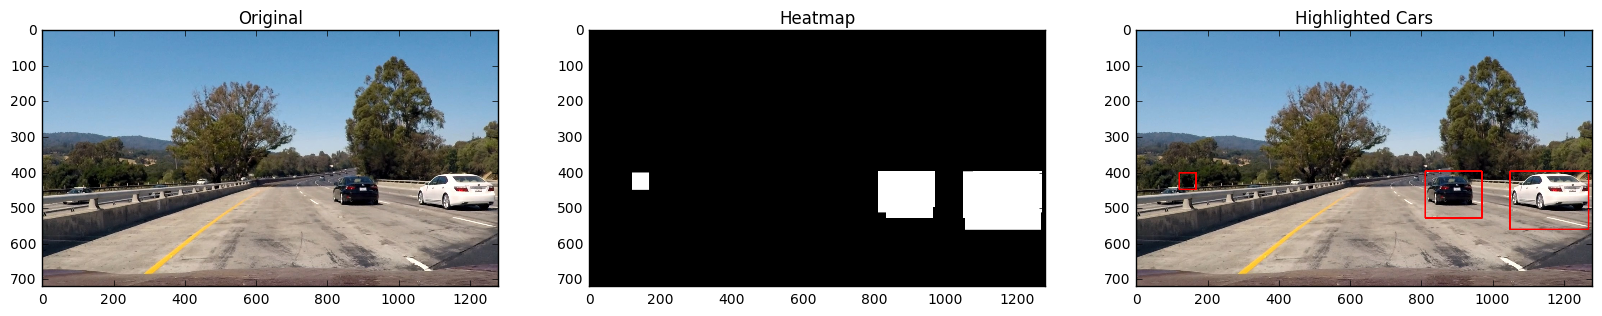

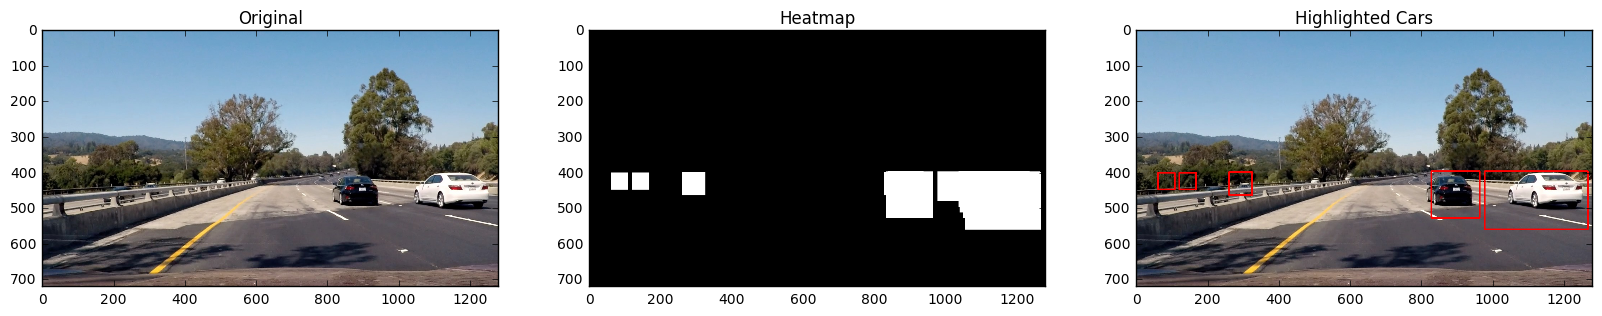

In [18]:
image_set = [0,3]

for i in image_set:
    image = cv2.imread(files_test[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = GetCarHeatmap(image,scaler, fs_model, classifier)
    binary = BinarizeHeatmap(mask,1)
    cars = GetCars(binary)
    rect = DrawRectangles(image,cars)
    
    plt.figure(figsize=(20,10))
    plt.subplot(131).set_title("Original")
    plt.imshow(image)
    plt.subplot(132).set_title("Heatmap")
    plt.imshow(np.uint8(mask),cmap='gray')
    plt.subplot(133).set_title("Highlighted Cars")
    plt.imshow(rect)
    plt.show()

## Video Processing

### Reduction of false positives by time averaging

To further try to reduce the presence of false positives, the method will be storing in memory a limited set of the last hetmaps generated and it will use an average heatmap to try generating the bounding box for each car. This allows the method to disregard false positives that might show up in a couple of the recorded frames in memory.

### Final Implementation Parameters

Using a double thresholding process in the video implementation allows me to not be very harsh in the minimum limit to consider in each filter. 

Since I am using 0.33 as the wOverlap parameter means that there will not be a hige density of "heat" in a particular spot and I will have to use a lower value as a threshold for individual images. After some testing, this process disregards any sections with just one detection.

The advantage of using a second threshold using an average of the last individual thresholded heatmaps (in this case, I am using the last 10) allows me to further correct false positives. After some testing, the method will be considering as a detection sections that are positive in at least 80% of the considered recorded heatmaps.

In [19]:
global heat_history

def InitializeCarDetection():
    global heat_history
    image_width = 1280
    image_height = 720
        
    heat_history = np.empty( (0, 720, 1280) )

def AddHeatmap(heatmap):
    global heat_history
    history_size = 10
    
    if (heat_history.shape[0] >= history_size):
        heat_history = np.delete(heat_history,0,0)
    
    heat_history = np.vstack( (heat_history, np.array([heatmap])) )
    
def GetHeatmap():
    global heat_history
    
    x = 1 + np.indices( (1, heat_history.shape[0]) )
    x = x / x.sum()
    
    return np.average(heat_history, axis=0)#, weights=x[1,0])

def CarDetection(image):
    mask = GetCarHeatmap(image,scaler, fs_model, classifier)
    mask = BinarizeHeatmap(mask,2)
    
    AddHeatmap(mask)
    heatmap = GetHeatmap()
    
    binary = BinarizeHeatmap(heatmap,0.8)
    
    cars = GetCars(binary)
    rect = DrawRectangles(image,cars)    
    
    return rect
    
    """
    if (binary.max() > 0):
        cars = GetCars(binary)
        rect = DrawRectangles(image,cars)    
    
        return rect
    else:
        return image
    """

In [20]:
InitializeCarDetection()

str_clip = _TEST_VIDEO_
clip_output = 'out_'+str_clip

clip2 = VideoFileClip(str_clip)
current_clip = clip2.fl_image(CarDetection)
%time current_clip.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video out_test_video.mp4
[MoviePy] Writing video out_test_video.mp4


 97%|████████████████████████████████████████████████████████████████████████████▉  | 38/39 [01:42<00:02,  2.54s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_test_video.mp4 

Wall time: 1min 43s


In [21]:
InitializeCarDetection()

str_clip = _PROJECT_VIDEO_
clip_output = 'out_'+str_clip

clip2 = VideoFileClip(str_clip)
current_clip = clip2.fl_image(CarDetection)
%time current_clip.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


100%|██████████████████████████████████████████████████████████████████████████▉| 1260/1261 [54:34<00:02,  2.46s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 

Wall time: 54min 34s


## Discussion

Using a perspective driven method to chose the size of the windows seems to be a good idea but it is important to be mindful of the parameters used. I started using a lot of bands and more overlap and the processing time got way too high and trying to find the best possible parameters required some iteration.

I think there is much room of improvement on the identification part of the method. It could be interesting to save a much more detailed Car class that could help us track each car's movement (its velocity, direction,...). This method also fuses to cars that are close by in a single label and maybe recording the car color, it could be possible to tell them apart.

It might be interesting to get a dataset recorded from the camera that is being used. Different cameras have different characteristics and it could help to fit a classifier using data similar to the input we are using.

It could also be useful to do perspective normalization on the sides of the image like we did for the lane. This might help mitigate diferences in shape due to the position of the other car in the real world.

It might also be interesting to try doing clasification using a convolutian neural network with softmax.

The method seems to perform well enough in a sunny highway with nearly no traffic but it would also be interesting to test its performance in a much more busy environment (city, high dense traffic, country road,...) and in different weather conditions (rain, snow, night,...).